In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import spacy
from spacy.lang.en.stop_words import STOP_WORDS as stopwords
from nltk.tokenize import word_tokenize

#For Stemming text
from nltk.stem import PorterStemmer        

import seaborn as sns
from wordcloud import WordCloud
from textblob import TextBlob

# Convert a collection of text documents to a matrix of token counts.
from sklearn.feature_extraction.text import CountVectorizer

#To split data into train and test
from sklearn.model_selection import train_test_split

#For fitting model
from sklearn.linear_model import LogisticRegression

#For evaluation of model
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')
nltk.download('punkt_tab')
sid = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt_tab to /usr/share/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


# Data collection

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("michiard/sentiment-analysis-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/sentiment-analysis-dataset


In [3]:
print(os.listdir(path))

df = pd.read_csv(path+'/train.csv')

print(df.head())

['sample_submission.csv', 'train.csv', 'test.csv']
       textID                                               text  \
0  28ac06f416                        good luck with your auction   
1  92098cf9a7  Hmm..You can`t judge a book by looking at its ...   
2  7858ff28f2   Hello, yourself. Enjoy London. Watch out for ...   
3  b0c9c67f32         We can`t even call you from belgium  sucks   
4  7b36e9e7a5                                 not so good mood..   

                                       selected_text sentiment  
0                        good luck with your auction  positive  
1  Hmm..You can`t judge a book by looking at its ...   neutral  
2                                    They`re mental.  negative  
3                                            m  suck  negative  
4                                 not so good mood..  negative  


In [4]:
print(df.info())
print("Columns: " + df.columns)
print(df.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24732 entries, 0 to 24731
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         24732 non-null  object
 1   text           24732 non-null  object
 2   selected_text  24732 non-null  object
 3   sentiment      24732 non-null  object
dtypes: object(4)
memory usage: 773.0+ KB
None
Index(['Columns: textID', 'Columns: text', 'Columns: selected_text',
       'Columns: sentiment'],
      dtype='object')
(24732, 4)


In [5]:
df.describe(include='all')

,textID,text,selected_text,sentiment
count,24732,24732,24732,24732
unique,24732,24732,20298,3
top,28ac06f416,good luck with your auction,love,neutral
freq,1,1,174,10018


In [6]:
df['sentiment'].value_counts()

sentiment
neutral     10018
positive     7711
negative     7003
Name: count, dtype: int64

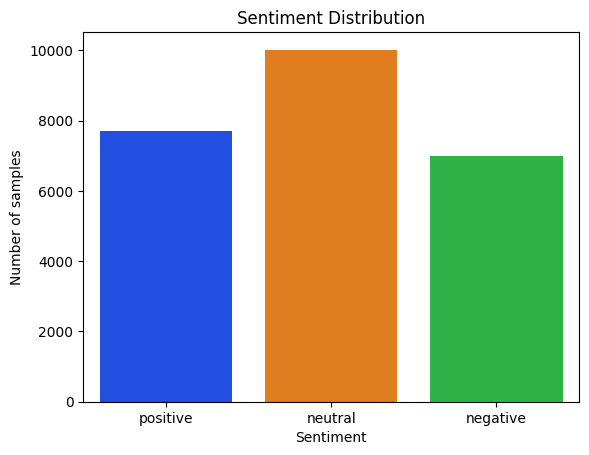

In [7]:
# Plot
sns.countplot(x='sentiment', data=df, palette='bright')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Number of samples')
plt.show()

# Preprocessing

## Text cleansing

In [8]:
'''
import nltk
import spacy
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string


# Carica modello spaCy
nlp = spacy.load("en_core_web_sm")

# Stopwords personalizzate (manteniamo le negazioni)
stop_words = set(stopwords.words('english'))
negations = {'no', 'not', 'nor'}
stop_words = stop_words.difference(negations)

def preprocess_text(text):
    # Rimuove punteggiatura
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Tokenizzazione
    tokens = word_tokenize(text.lower())
    
    # Lemmatizzazione con spaCy (sul testo completamente lowercase)
    doc = nlp(" ".join(tokens).lower())
    lemmatized_tokens = [token.lemma_.lower() for token in doc]

    
    # Rimozione stopwords
    final_tokens = [token for token in lemmatized_tokens if token not in stop_words and token.strip()]
    
    return final_tokens

df['removed_stop_words'] = df['text'].apply(lambda x: preprocess_text(x))
'''

'\nimport nltk\nimport spacy\nfrom nltk.corpus import stopwords\nfrom nltk.tokenize import word_tokenize\nimport string\n\n\n# Carica modello spaCy\nnlp = spacy.load("en_core_web_sm")\n\n# Stopwords personalizzate (manteniamo le negazioni)\nstop_words = set(stopwords.words(\'english\'))\nnegations = {\'no\', \'not\', \'nor\'}\nstop_words = stop_words.difference(negations)\n\ndef preprocess_text(text):\n    # Rimuove punteggiatura\n    text = text.translate(str.maketrans(\'\', \'\', string.punctuation))\n    \n    # Tokenizzazione\n    tokens = word_tokenize(text.lower())\n    \n    # Lemmatizzazione con spaCy (sul testo completamente lowercase)\n    doc = nlp(" ".join(tokens).lower())\n    lemmatized_tokens = [token.lemma_.lower() for token in doc]\n\n    \n    # Rimozione stopwords\n    final_tokens = [token for token in lemmatized_tokens if token not in stop_words and token.strip()]\n    \n    return final_tokens\n\ndf[\'removed_stop_words\'] = df[\'text\'].apply(lambda x: preprocess

In [9]:
!pip install spacy nltk num2words
!python -m nltk.downloader punkt stopwords
!python -m spacy download en_core_web_sm


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.5/163.5 kB 7.3 MB/s eta 0:00:00
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=69af1bb32a0036dcc4faa5bd61b62fc7af8b7d6f600768b7a20f5f8b32e6f72f
  Stored in directory: /root/.cache/pip/wheels/1a/b0/8c/4b75c4116c31f83c8f9f047231251e13cc74481cca4a78a9ce
Successfully built docopt
<frozen runpy>:128: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 74.8 MB/s eta 0:00:00:00:010:01
✔ Download and installation successful
You can now load the packag

In [10]:
import re
import string
import unicodedata
import nltk
import spacy
from nltk.corpus import stopwords
from num2words import num2words

# Downloads if needed
nltk.download('stopwords')

# Load spaCy model
nlp = spacy.load("en_core_web_sm")

# Custom stopwords keeping negations
stop_words = set(stopwords.words('english'))
negations = {'no', 'not', 'nor'}
stop_words = stop_words.difference(negations)

def preprocess_text(text):
    # 1. Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # 2. Remove mentions and hashtags
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#\w+', '', text)
    
    # 3. Remove accented characters
    text = unicodedata.normalize('NFKD', text).encode('ASCII', 'ignore').decode('utf-8', 'ignore')
    
    # 4. Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # 5. Convert numbers to words
    def replace_numbers(match):
        return num2words(match.group())
    text = re.sub(r'\b\d+\b', replace_numbers, text)
    
    # 6. Lowercase
    text = text.lower()
    
    # 7. Lemmatize and tokenize with spaCy
    doc = nlp(text)
    
    # 8. Remove stopwords and non-alpha tokens
    tokens = [
        token.lemma_.lower()
        for token in doc
        if token.lemma_.lower() not in stop_words and token.lemma_.isalpha()
    ]
    
    return tokens


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
df['removed_stop_words'] = df['text'].apply(lambda x: preprocess_text(x))

In [12]:
df.sample(10)

,textID,text,selected_text,sentiment,removed_stop_words
6944,74b7668a11,GOING TO WATCH SUPERNATURAL shall return after...,GOING TO WATCH SUPERNATURAL shall return after...,neutral,"[go, watch, supernatural, shall, return, after..."
9826,f931ba6f23,i have a headache,headache,negative,[headache]
21734,ac0614892c,at thee mall,at thee mall,neutral,"[thee, mall]"
16673,aa2cabbf58,ekkk..thats ruff..hope you have a safe flight...,good,positive,"[ekkkthat, ruffhope, safe, flight, good, meeting]"
17753,b7e2a08a74,i never knew a dentention was so hard 2 get,i never knew a dentention was so hard,negative,"[never, know, dentention, hard, two, get]"
21168,61e828e74d,_xD Si pero parece que las personas de facebo...,I tried,negative,"[xd, si, pero, parece, que, las, personas, de,..."
13265,f3aaecc932,"hope you have a great weekend,Paris",great,positive,"[hope, great, weekendparis]"
24199,6d102deeab,"hey i loved ACS but i had to see it online, i...","y i loved ACS but i had to see it online, is n...",positive,"[hey, love, acs, see, online, not, yet, not, w..."
16703,7e83650656,"I have a question for you, Ali.","I have a question for you, Ali.",neutral,"[question, ali]"
384,449060ebc8,"Boss just texted me, I HAVE THE DAY OFF! YES< ...","Boss just texted me, I HAVE THE DAY OFF! YES< ...",neutral,"[boss, texte, day, yes, yes, yes]"


In [13]:
df[df['removed_stop_words'].apply(lambda tokens: 'mother' in tokens)]


,textID,text,selected_text,sentiment,removed_stop_words
19,fe54c45844,can`t believe I just drove all the way back to...,HAPPY,positive,"[not, believe, drive, way, back, schoolwhateve..."
52,f22dd850f7,happy mother`s day to all the moms out there. ...,happy mother`s day,positive,"[happy, mother, day, mom, hope, never, join, c..."
63,4e53704d24,in about 30 minutes Happy Mothers Day to alll ...,Happy,positive,"[thirty, minute, happy, mother, day, alll, ama..."
93,ee91ba580f,Happy Mother`s Day ~ Did you watch SNL? If n...,Happy Mother`s Day,positive,"[happy, mother, day, watch, snl, not, u, miss,..."
110,8976579aa1,"Mom, where ever you are; Happy Mothers day",Happy,positive,"[mom, ever, happy, mother, day]"
...,...,...,...,...,...
24548,dbb2960dc7,Searching my home for a few things to cook the...,Searching my home for a few things to cook the...,neutral,"[search, home, thing, cook, dinner, evening, m..."
24588,ba0f683c89,"Wishing you a very Happy Mother`s Day, Carina...",Happy,positive,"[wish, happy, mother, day, carina, hugsjoy]"
24626,563148673a,happy mothers day,happy mo,positive,"[happy, mother, day]"
24691,a1c8f1e077,Happy Mothers Day! i hope tom got you somethi...,Happy Mothers Day!,positive,"[happy, mother, day, hope, tom, get, something..."


In [14]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Define the unique sentiment classes you want to generate clouds for
sentiments = ['neutral', 'positive', 'negative']

# Loop through each class
for sentiment in sentiments:
    # Filter the DataFrame by sentiment class
    subset = df[df['sentiment'] == sentiment]

    # Flatten the token lists into a single string
    all_words = ' '.join([' '.join(tokens) for tokens in subset['removed_stop_words']])

    # Generate the word cloud
    wc = WordCloud(width=800, height=400, background_color='white').generate(all_words)

    # Display the word cloud (optional)
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'{sentiment.capitalize()} WordCloud', fontsize=16)

    # Save the figure locally
    filename = f"{sentiment}_wordcloud.png"
    plt.savefig(filename, bbox_inches='tight')
    plt.close()  # Close the plot to avoid displaying all of them in notebook

    print(f"Saved: {filename}")


Saved: neutral_wordcloud.png
Saved: positive_wordcloud.png
Saved: negative_wordcloud.png


# CNN + BiLSTM + Attention

- Embedding Layer: Learns word embeddings during training (no GloVe used).
- Conv1D Layer: Captures local patterns like n-grams (e.g., "not good").
- MaxPooling1D: Reduces dimensionality while keeping important features.
- Bidirectional LSTM: Captures context from both past and future tokens.
- Attention Layer: Helps the model focus on important parts of the input (e.g., emotional words).
- Dense Layers + Dropout: For classification and regularization.

In [25]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Bidirectional
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score

from tensorflow.keras.layers import Layer
import tensorflow as tf

class Attention(Layer):
    def __init__(self):
        super(Attention, self).__init__()

    def call(self, inputs):
        score = tf.nn.tanh(inputs)
        attention_weights = tf.nn.softmax(score, axis=1)
        context_vector = attention_weights * inputs
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector


# --- Assume df with 'text' and 'label' columns ---

texts = df['text'].values
labels = df['label'].values  # numeric labels 0,1,2

# --- Step 1: split train / val / test ---

train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    texts, labels, test_size=0.3, stratify=labels, random_state=42)

val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42)

print(f"Train size: {len(train_texts)}, Validation size: {len(val_texts)}, Test size: {len(test_texts)}")

# --- Step 2: Tokenize and pad ---

MAX_VOCAB = 10000
MAX_LEN = 100 
embedding_dim = 100

tokenizer = Tokenizer(num_words=MAX_VOCAB, oov_token="<OOV>")
tokenizer.fit_on_texts(train_texts)  # Fit ONLY on train data

def preprocess(texts):
    sequences = tokenizer.texts_to_sequences(texts)
    padded = pad_sequences(sequences, maxlen=MAX_LEN, padding='post', truncating='post')
    return padded

X_train = preprocess(train_texts)
X_val = preprocess(val_texts)
X_test = preprocess(test_texts)

y_train = train_labels
y_val = val_labels
y_test = test_labels

# --- Step 3: Build model ---

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout

inputs = Input(shape=(MAX_LEN,))
x = Embedding(input_dim=MAX_VOCAB, output_dim=embedding_dim, input_length=MAX_LEN)(inputs)
x = Conv1D(filters=128, kernel_size=5, activation='relu')(x)
x = MaxPooling1D(pool_size=2)(x)
x = Bidirectional(LSTM(64, return_sequences=True))(x)  # return_sequences=True for Attention
x = Attention()(x)  # <-- Custom Attention layer added here
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.4)(x)
outputs = Dense(3, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

# --- Step 4: Train ---

history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=10,
                    batch_size=64,
                    verbose=2)

# --- Step 5: Evaluate on validation ---

val_preds = model.predict(X_val).argmax(axis=1)
print("Validation Macro F1:", f1_score(y_val, val_preds, average='macro'))
print(classification_report(y_val, val_preds))

# --- Step 6: Evaluate on test ---

test_preds = model.predict(X_test).argmax(axis=1)
print("Test Macro F1:", f1_score(y_test, test_preds, average='macro'))
print(classification_report(y_test, test_preds))


Train size: 17312, Validation size: 3710, Test size: 3710


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_4 (Embedding)              │ (None, 100, 100)            │       1,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_4 (Conv1D)                    │ (None, 96, 128)             │          64,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_4 (MaxPooling1D)       │ (None, 48, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_4 (Bidirectional)      │ (None, 48, 128)             │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ attention (Attention)                │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,179,843 (4.50 MB)

 Trainable params: 1,179,843 (4.50 MB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_4 (Embedding)              │ (None, 100, 100)            │       1,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_4 (Conv1D)                    │ (None, 96, 128)             │          64,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_4 (MaxPooling1D)       │ (None, 48, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_4 (Bidirectional)      │ (None, 48, 128)             │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ attention (Attention)                │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,179,843 (4.50 MB)

 Trainable params: 1,179,843 (4.50 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
271/271 - 34s - 127ms/step - accuracy: 0.5102 - loss: 0.9699 - val_accuracy: 0.6782 - val_loss: 0.7469
Epoch 2/10
271/271 - 27s - 101ms/step - accuracy: 0.7258 - loss: 0.6711 - val_accuracy: 0.7218 - val_loss: 0.6758
Epoch 3/10
271/271 - 27s - 100ms/step - accuracy: 0.8051 - loss: 0.5223 - val_accuracy: 0.7208 - val_loss: 0.6970
Epoch 4/10
271/271 - 27s - 101ms/step - accuracy: 0.8651 - loss: 0.3895 - val_accuracy: 0.6957 - val_loss: 0.8117
Epoch 5/10
271/271 - 27s - 100ms/step - accuracy: 0.9039 - loss: 0.2889 - val_accuracy: 0.6849 - val_loss: 1.0467
Epoch 6/10
271/271 - 27s - 100ms/step - accuracy: 0.9329 - loss: 0.2175 - val_accuracy: 0.6879 - val_loss: 1.0692
Epoch 7/10
271/271 - 27s - 98ms/step - accuracy: 0.9538 - loss: 0.1578 - val_accuracy: 0.6809 - val_loss: 1.1161
Epoch 8/10
271/271 - 27s - 100ms/step - accuracy: 0.9644 - loss: 0.1222 - val_accuracy: 0.6792 - val_loss: 1.3221
Epoch 9/10
271/271 - 27s - 100ms/step - accuracy: 0.9711 - loss: 0.1019 - val_accuracy: 0

# LSTM

In [56]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, f1_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SpatialDropout1D, LSTM, Dense
from tensorflow.keras.utils import to_categorical

In [57]:
# Keras & Tuner
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SpatialDropout1D, LSTM, Dense
import keras_tuner as kt

In [58]:
# Preprocessing
data = df[['text', 'sentiment']].copy()

In [59]:
# Pulizia testo
data['text'] = data['text'].str.lower()
data['text'] = data['text'].apply(lambda x: re.sub(r'[^a-zA-Z0-9\s]', '', x))
data['text'] = data['text'].apply(lambda x: x.replace('rt', ''))

In [60]:
# Codifica etichette multiclasse
le = LabelEncoder()
data['label'] = le.fit_transform(data['sentiment'])  # negative=0, neutral=1, positive=2

In [61]:
# Tokenizzazione
max_features = 2000
tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(data['text'].values)
X = tokenizer.texts_to_sequences(data['text'].values)
X = pad_sequences(X)
y = data['label'].values

In [62]:
# Split
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1765, stratify=y_temp, random_state=42)

In [63]:
# One-hot encoding
Y_train = to_categorical(y_train, num_classes=3)
Y_val = to_categorical(y_val, num_classes=3)
Y_test = to_categorical(y_test, num_classes=3)

print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

Train: (17311, 32), Val: (3711, 32), Test: (3710, 32)


In [64]:
# %%
# Keras Tuner - model builder
def build_model(hp):
    model = Sequential()
    model.add(Embedding(max_features,
                        hp.Int('embed_dim', min_value=64, max_value=256, step=32),
                        input_length=X.shape[1]))
    model.add(SpatialDropout1D(hp.Float('spatial_dropout', 0.1, 0.5, step=0.1)))
    model.add(LSTM(
        hp.Int('lstm_units', min_value=64, max_value=256, step=32),
        dropout=hp.Float('dropout', 0.1, 0.5, step=0.1),
        recurrent_dropout=hp.Float('recurrent_dropout', 0.1, 0.5, step=0.1)
    ))
    model.add(Dense(3, activation='softmax'))
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

In [65]:
# %%
# Tuning
tuner = kt.Hyperband(build_model,
                     objective='val_accuracy',
                     max_epochs=5,
                     factor=3,
                     directory='kt_dir',
                     project_name='lstm_multiclass')

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)

tuner.search(X_train, Y_train, epochs=5, validation_data=(X_val, Y_val), callbacks=[stop_early], verbose=2)

# %%
# Miglior modello
best_model = tuner.get_best_models(num_models=1)[0]

Trial 10 Complete [00h 02m 45s]
val_accuracy: 0.7049312591552734

Best val_accuracy So Far: 0.710590124130249
Total elapsed time: 00h 22m 49s


In [66]:
# %%
# Valutazione finale
print("\n📊 Test Evaluation:")
score, acc = best_model.evaluate(X_test, Y_test, verbose=0)
print(f"Test score: {score:.4f}, accuracy: {acc:.4f}")


📊 Test Evaluation:
Test score: 0.6798, accuracy: 0.7127


In [67]:
# %%
# Report completo
y_pred = best_model.predict(X_test).argmax(axis=1)
y_true = y_test
print(f"\nTest Macro F1 Score: {f1_score(y_true, y_pred, average='macro'):.4f}")
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=le.classes_))

116/116 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step

Test Macro F1 Score: 0.7139

Classification Report:
              precision    recall  f1-score   support

    negative       0.72      0.62      0.67      1050
     neutral       0.64      0.77      0.70      1503
    positive       0.84      0.72      0.77      1157

    accuracy                           0.71      3710
   macro avg       0.73      0.70      0.71      3710
weighted avg       0.73      0.71      0.71      3710

